<a href="https://colab.research.google.com/github/ayyildizg/ayyildizgulinlab.7/blob/main/%D0%9B%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%BE%D1%80%D0%BD%D0%B0%D1%8F_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Лабораторная 7. Сентимент-анализ
Задачи классификации текста аналогично обычной задаче классификации предполагает присвоение метки класса некоторому тексту. Здесь можно действовать любыми методами для того, чтобы классифицировать текст, но мы пойдем по следующему пути: векторизуем последовательности (обязательно почитайте про подходы к векторизации, об эмбеддингах) и обучим RNN

После обучения базовых моделей разрешается использовать любой другой подход

За выполнение базовой работы можно получить 15 баллов, за преодоление отметки в 94% точности классификации еще 5 баллов Удачи!

Примечание: обязательно почитайте про лемматизацию, стеминг, TF-IDF и Word2Vec подходы



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.metrics import roc_auc_score, precision_score, recall_score, roc_curve, accuracy_score

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from collections import Counter
from string import punctuation

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from gensim.models import Word2Vec
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader , TensorDataset

lemma = WordNetLemmatizer()
lb = LabelEncoder()

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
df = pd.read_csv('twitter_training.csv', header=None)
df.head()

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [ ]:
np.unique(df[1])

array(['Amazon', 'ApexLegends', 'AssassinsCreed', 'Battlefield',
       'Borderlands', 'CS-GO', 'CallOfDuty', 'CallOfDutyBlackopsColdWar',
       'Cyberpunk2077', 'Dota2', 'FIFA', 'Facebook', 'Fortnite', 'Google',
       'GrandTheftAuto(GTA)', 'Hearthstone', 'HomeDepot',
       'LeagueOfLegends', 'MaddenNFL', 'Microsoft', 'NBA2K', 'Nvidia',
       'Overwatch', 'PlayStation5(PS5)',
       'PlayerUnknownsBattlegrounds(PUBG)', 'RedDeadRedemption(RDR)',
       'TomClancysGhostRecon', 'TomClancysRainbowSix', 'Verizon',
       'WorldOfCraft', 'Xbox(Xseries)', 'johnson&johnson'], dtype=object)

In [ ]:
df = df.drop(0 , axis=1)

In [ ]:
df= df.rename(columns={1:"Feature2",3:"Feature1",2: "labels"})

In [ ]:
df.head()

,Feature2,labels,Feature1
0,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,Borderlands,Positive,I am coming to the borders and I will kill you...
2,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,Borderlands,Positive,im coming on borderlands and i will murder you...
4,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [ ]:
df["tweets"]= df["Feature1"].astype(str) +" "+ df["Feature2"].astype(str)
df= df.drop(["Feature1","Feature2"],axis=1)
df.head()

,labels,tweets
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [ ]:
df_labels = {key : value for value , key in enumerate(np.unique(df['labels']))}
df_labels

{'Irrelevant': 0, 'Negative': 1, 'Neutral': 2, 'Positive': 3}

In [ ]:
def getlabel(n) :
    for x , y in df_labels.items() :
        if y==n :
            return x

In [ ]:
def DataPrep(text) :
    text = re.sub('<.*?>', '', text) # HTML tags
    text = re.sub(r'\d+', '', text) # numbers
    text = re.sub(r'[^\w\s]', '', text) # special characters
    text = re.sub(r'http\S+', '', text) # URLs or web links
    text = re.sub(r'@\S+', '', text) # mentions
    text = re.sub(r'#\S+', '', text) # hashtags

    # tokenization
    tokens = nltk.word_tokenize(text)

    # remove puncs
    punc = list(punctuation)
    words = [word for word in tokens if word not in punc]

    # remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word.lower() in stop_words]

    # Lemmatization
    words = [lemma.lemmatize(word) for word in words]

    text = ' '.join(words)

    return text

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
df['cleaned_tweets'] = df['tweets'].apply(DataPrep)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
print(f'There are around {int(df["cleaned_tweets"].duplicated().sum())} duplicated tweets, we will remove them.')
df.drop_duplicates("cleaned_tweets", inplace=True)
df['tweet_len'] = [len(text.split()) for text in df.cleaned_tweets]
df = df[df['tweet_len'] < df['tweet_len'].quantile(0.995)]

There are around 11865 duplicated tweets, we will remove them.


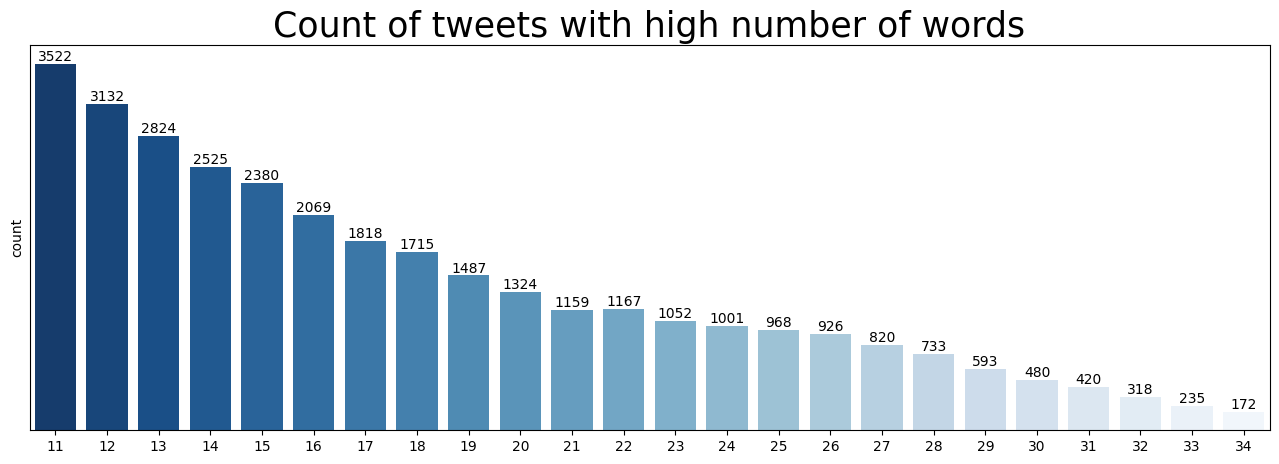

In [ ]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='tweet_len', data=df[(df['tweet_len']<=1000) & (df['tweet_len']>10)], palette='Blues_r')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()